In [38]:
!pip install pillow

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8024473664467333839
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3061265204
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13996877345791057756
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import os
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2

In [20]:
dataset_df = pd.read_csv("input/train_labels.csv")
dataset_df["filename"] = [item.id+".tif" for idx, item in dataset_df.iterrows()]
dataset_df["groundtruth"] = ["cancerous" if item.label==1 else "healthy" for idx, item in dataset_df.iterrows()]
dataset_df.head()

,id,label,filename,groundtruth
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,healthy
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,cancerous
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,healthy
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,healthy
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,healthy


In [21]:
training_sample_percentage = 0.8
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

# Load the dataset

In [22]:
training_batch_size = 64
validation_batch_size = 64
target_size = (96,96)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='groundtruth',
    directory='input/train/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='groundtruth',
    directory='input/train/',
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size,
    class_mode='binary')


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [23]:
def plot_random_samples(generator):
    generator_size = len(generator)
    index=random.randint(0,generator_size-1)
    image,label = generator.__getitem__(index)

    sample_number = 10
    fig = plt.figure(figsize = (20,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(image[i])
        if label[i]==0:
            ax.set_title("Cancerous cells")
        elif label[i]==1:
            ax.set_title("Healthy cells")
    plt.tight_layout()
    plt.show()

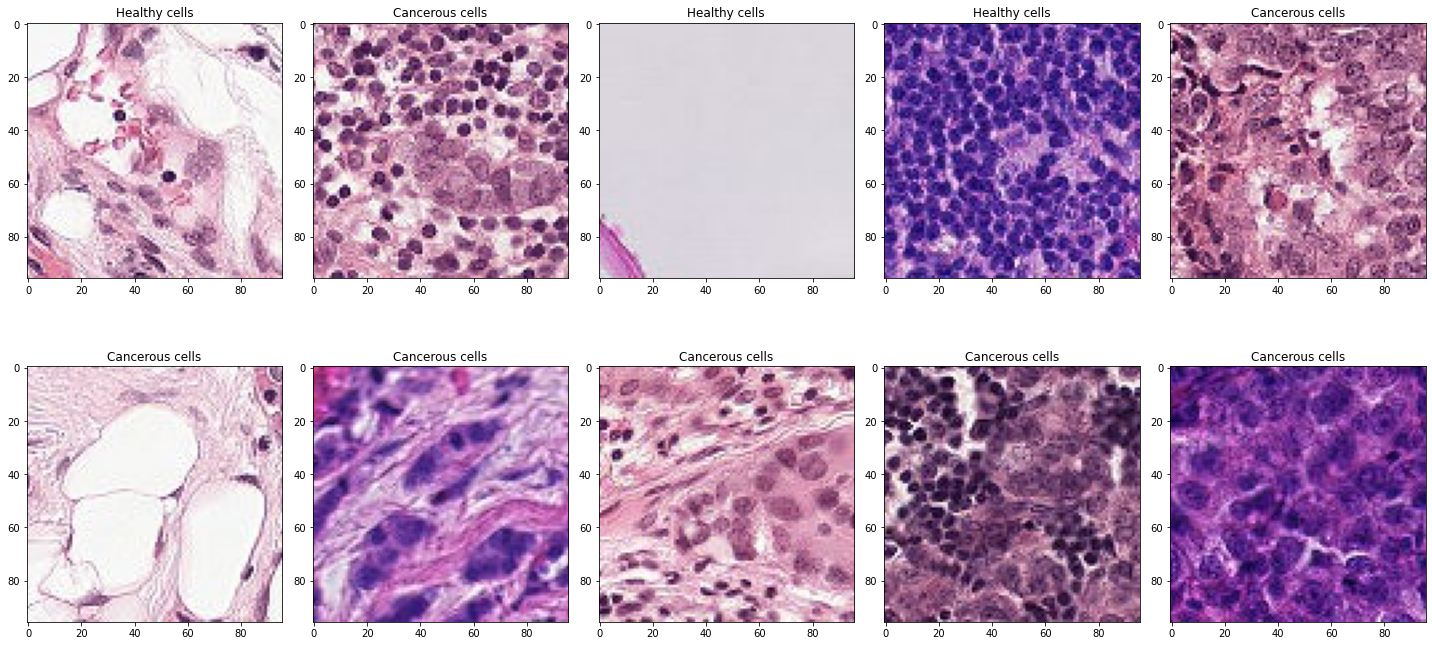

In [24]:
plot_random_samples(validation_generator)

# Create the model: Use a pretrained MobileNet

In [25]:
input_shape = (96, 96, 3)
pretrained_layers = MobileNetV2(weights='imagenet',include_top = False, input_shape=input_shape)
pretrained_layers.summary()

9412608/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
_________________

We freeze all the layers except the 8 last, before checking the "trainable" status of the all the layers in our VGG16.

In [26]:
for layer in pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in pretrained_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000019E6037F320> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000019E60398D30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000019E603DB198> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000019E603D64A8> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x0000019E5F7CE518> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x0000019E603E5898> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000019E603E5EB8> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x0000019E6043BC88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000019E6043BA90> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000019E6048F9E8> False
<tensorflow.python.keras.layers.convolutional.

We proceed to create the model by adding the pretrained VGG16 and then our bottleneck layers which will finish with a binary classification.

In [27]:
dropout_dense_layer = 0.5

model = Sequential()
model.add(pretrained_layers)
    
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327680    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [30]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

train_step_size = train_generator.n // train_generator.batch_size
validation_step_size = validation_generator.n // validation_generator.batch_size

In [31]:
epochs = 10
history = model.fit_generator(train_generator,
          steps_per_epoch = train_step_size,
          validation_data= validation_generator,
          validation_steps = validation_step_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2750 steps, validate for 687 steps
Epoch 1/10
2750/2750 [==============================] - 439s 160ms/step - loss: 0.3353 - accuracy: 0.8573 - val_loss: 0.4921 - val_accuracy: 0.7729
Epoch 2/10
2749/2750 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8734
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2750/2750 [==============================] - 391s 142ms/step - loss: 0.3030 - accuracy: 0.8733 - val_loss: 0.8890 - val_accuracy: 0.7006
Epoch 3/10
2749/2750 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8811
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2750/2750 [==============================] - 371s 135ms/step - loss: 0.2850 - accuracy: 0.8810 - val_loss: 0.5009 - val_accuracy: 0.7553
Epoch 4/10
2749/2750 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8869
Epoch 00004: ReduceLROnPlatea

# Plotting performance during training

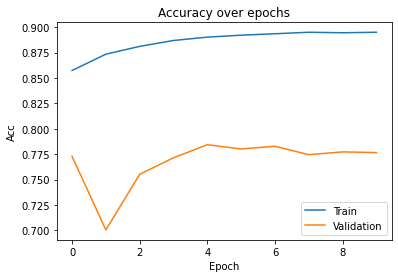

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

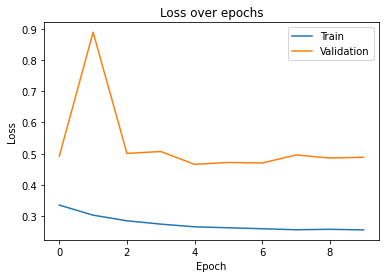

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [34]:
import pickle
with open('trainHistoryMobilenet', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)

In [35]:
model.save('MobileV25epo.h5')

In [ ]:
pred=model.predict_generator(test_generator,verbose=1)

1375/1375 [==============================] - 3419s 2s/step - loss: 0.5451 - accuracy:0.8427

In [ ]:
model.load_weights("best_model.h5")